## Cluster time-series using DTW

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import load_google_mobility, load_deaths, load_interventions, load_counties, load_google_mobility_time_series
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

import pickle

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

Mobility Last Updated 04-26
Deaths Last Updated 04-26


In [3]:
# Ignore places with FIPS missing
deaths = deaths.dropna(axis=0, subset=['FIPS']).astype({'FIPS':'int32'})
deaths = deaths.merge(counties['FIPS'], on='FIPS', how='inner')

In [4]:
# Get columns that are dates
death_dates = get_date_columns(deaths, return_dtimes=False)

In [5]:
def normalize(row):
    FIPS = row['FIPS']
    pop = counties[counties['FIPS'] == FIPS]['POP_ESTIMATE_2018']
    return(row[death_dates] / int(pop))
    
def get_onset_date(row, thresh = 5):
    above = row[row > thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

In [6]:
## Normalize deaths by pop total
deaths = deaths[['FIPS']+death_dates]

deaths['onset'] = deaths[death_dates].apply(lambda row: get_onset_date(row), axis=1)

deaths = deaths.dropna(axis=0, subset=['onset'])

deaths[death_dates] = deaths.apply(lambda row: normalize(row), axis=1)

In [7]:
deaths_df = deaths[deaths['onset'].apply(lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= 7)]

In [8]:
def DTWDistance(s1, s2,w=5):
    s1 = s1[s1 >= 0]
    s2 = s2[s2 >= 0]
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [9]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [10]:
n = 3
deaths_np = deaths_df.apply(lambda row: [row[d] for d in death_dates if (str2date(row['onset']) - str2date(d)).days <= n-1],axis=1)

deaths_np = [moving_average(d, n=n) for d in deaths_np]

In [71]:
max_length = max([len(d) for d in deaths_np])
distmat = pairwise_distances([np.hstack((d, [-1]*(max_length - len(d)))) for d in deaths_np], metric=DTWDistance)

In [73]:
np.save('../data/intermediates/dtw_distmat', distmat)

In [11]:
distmat = np.load('../data/intermediates/dtw_distmat.npy')

In [12]:
n_clusters = np.arange(3,10,1)
#linkage = ['average', 'ward', '']
for n_clusters in np.arange(3,10,1):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', affinity='precomputed').fit(distmat)
    score = silhouette_score(distmat, clustering.labels_, metric='precomputed')
    print(f'{n_clusters}: {score}')

3: 0.5450836737669922
4: 0.5791789321626356
5: 0.6282699246597335
6: 0.6402778782923592
7: 0.6265909873390871
8: 0.4822592942842327
9: 0.4783608323833335


In [13]:
def plot(labels, label, n = 5):
    idxs = np.where(labels == label)[0][:n]
    n = min(len(idxs), n)
    fig,axes = plt.subplots(n,1,figsize=(1.5*n,1.5*n), sharex=True)
    if n == 1:
        axes = [axes]
    for i,idx in enumerate(idxs):
        y = deaths_np[idx]
        FIPS = deaths_df.iloc[idx]['FIPS']
        l = ', '.join(counties[counties['FIPS'] == FIPS][['Area_Name', 'State']].values[0])
        axes[i].plot(np.arange(len(y)), y, label=l)
        axes[i].legend(loc='upper left')
    axes[0].set_title(f'Cluster {label}, Size={len(np.where(labels == label)[0])}')

In [14]:
clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='precomputed').fit(distmat)

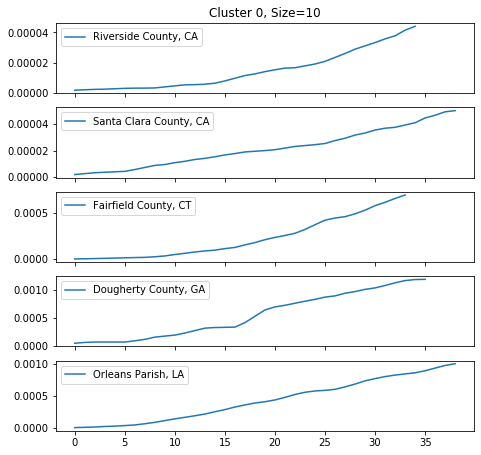

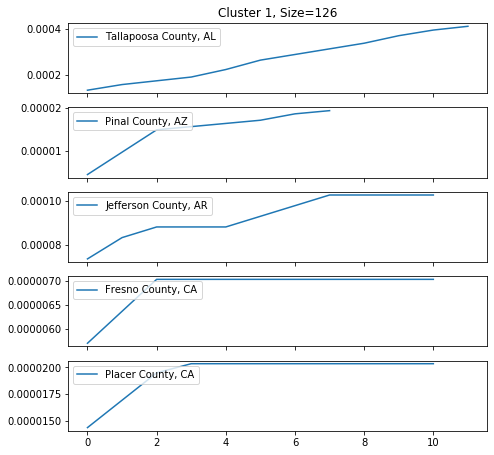

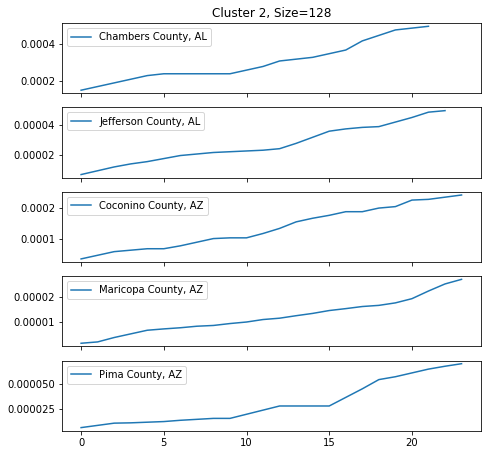

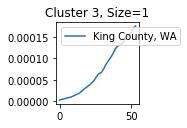

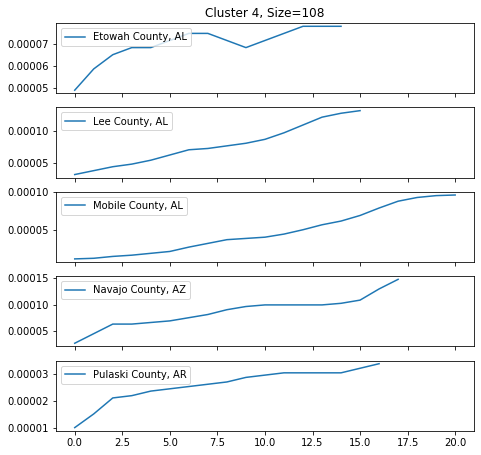

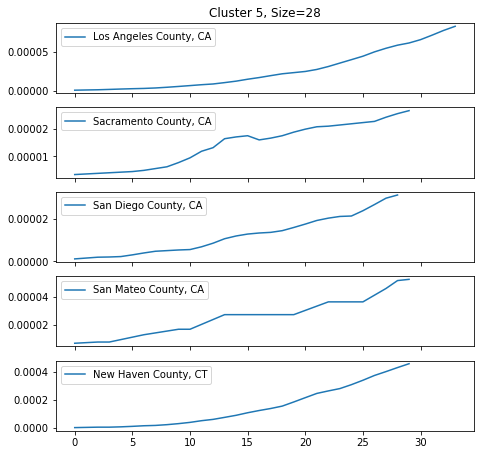

In [15]:
for label in np.unique(clustering.labels_):
    plot(clustering.labels_, label=label, n=5)